In [62]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras import optimizers 
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from time import time
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Activation, Dense

from keras.utils import np_utils

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12)
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report, f1_score, accuracy_score
import glob
import warnings
import pandas as pd
import numpy as np

import os

## Load dataset

In [63]:
path_dataset = "Dataset/WISDM/WISDM_ar_v1.1/a.txt"

In [64]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv(path_dataset, header = None, names = columns )
df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [65]:
df =df[df.activity != 'Jogging']

In [66]:
df = df[df.activity != 'Downstairs']

In [67]:
null_counts = df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
user         0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64


In [68]:
print(df['activity'])

597        Walking
598        Walking
599        Walking
600        Walking
601        Walking
602        Walking
603        Walking
604        Walking
605        Walking
606        Walking
607        Walking
608        Walking
609        Walking
610        Walking
611        Walking
612        Walking
613        Walking
614        Walking
615        Walking
616        Walking
617        Walking
618        Walking
619        Walking
620        Walking
621        Walking
622        Walking
623        Walking
624        Walking
625        Walking
626        Walking
            ...   
1098174    Sitting
1098175    Sitting
1098176    Sitting
1098177    Sitting
1098178    Sitting
1098179    Sitting
1098180    Sitting
1098181    Sitting
1098182    Sitting
1098183    Sitting
1098184    Sitting
1098185    Sitting
1098186    Sitting
1098187    Sitting
1098188    Sitting
1098189    Sitting
1098190    Sitting
1098191    Sitting
1098192    Sitting
1098193    Sitting
1098194    Sitting
1098195    S

## Data preprocessing

In [69]:
N_TIME_STEPS = 60
N_FEATURES = 3
step = 124
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

C:\Users\fifamd\Anaconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [70]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [71]:
RANDOM_SEED = 42

In [72]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [73]:
print(len(segments))

5287


## Transfer

In [74]:
from keras.models import Model
from keras.layers import Input, Dense,LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras import optimizers 
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from tensorflow import set_random_seed

import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import classification_report, f1_score, accuracy_score

In [75]:
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [76]:
print(X_train.shape)
print(y_train.shape)
print(reshaped_segments.shape)
numOfRows = reshaped_segments.shape[1]
numOfColumns = reshaped_segments.shape[2]
filters = 32
Epochs = 100
batchSize = 10
num_class = 4
print(numOfRows , numOfColumns)
print(y_train)

(4229, 60, 3)
(4229, 4)
(5287, 60, 3)
60 3
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 ..., 
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


## Model

In [77]:
def TCNN():
    base_model1 = Input(shape=(numOfRows,numOfColumns))
    base_model = Conv1D(filters,(11),activation = 'relu')(base_model1)
    base_model = MaxPooling1D(pool_size=2)(base_model)
    base_model = Conv1D(filters,(11), activation = 'relu')(base_model)
    base_model = MaxPooling1D(pool_size=2)(base_model)

    base_model = LSTM(128)(base_model)

    base_model = Dense(256)(base_model)
    base_model = Dropout(0.5)(base_model)
    base_model = Dense(4,activation="softmax")(base_model)
    model = Model(inputs=[base_model1], outputs=base_model)
    adam = optimizers.Adam(lr = 0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [78]:
m = TCNN()
m.summary()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=10,
                                verbose=1, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=20, verbose=0, mode='max')

model_1_path = "./model/model_1/{}.h5".format("model_1")
checkpoint = ModelCheckpoint(model_1_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

history = m.fit(X_train,y_train, validation_split = 0.2, epochs = Epochs, callbacks=callbacks_list, verbose =1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 3)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 32)            1088      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 15, 32)            11296     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
__________

Epoch 25/100
3328/3383 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9964
Epoch 00025: val_acc did not improve
3383/3383 [==============================] - 2s 543us/step - loss: 0.0106 - acc: 0.9965 - val_loss: 0.3319 - val_acc: 0.9468
Epoch 26/100
3328/3383 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9967
Epoch 00026: val_acc did not improve
3383/3383 [==============================] - 2s 537us/step - loss: 0.0105 - acc: 0.9967 - val_loss: 0.3117 - val_acc: 0.9504
Epoch 27/100
3296/3383 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9985
Epoch 00027: val_acc did not improve
3383/3383 [==============================] - 2s 542us/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.2865 - val_acc: 0.9515
Epoch 28/100
3264/3383 [===========================>..] - ETA: 0s - loss: 0.0077 - acc: 0.9969
Epoch 00028: val_acc did not improve
3383/3383 [==============================] - 2s 538us/step - loss: 0.0075 - acc: 0.9970 - val_los

## Plot acc and loss

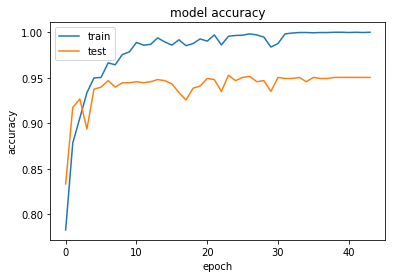

In [79]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

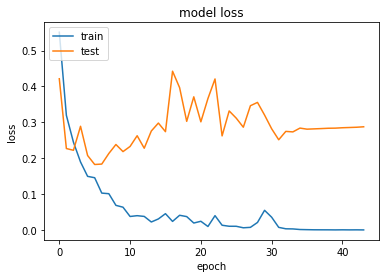

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict

In [81]:
label = ['Walking','Standing','Sitting','Upstaris']

In [82]:
y_pred = m.predict(X_test)

In [83]:
y_pred = np.argmax(y_pred, axis=1)

In [84]:
y_pred = np_utils.to_categorical(y_pred, num_class)

In [85]:
y_pred = np.array(y_pred)
y_test = np.array(y_test)

In [86]:
print(y_pred)
print(y_test)

[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 ..., 
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 ..., 
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


## Visualization

In [87]:
%run eval_score.ipynb

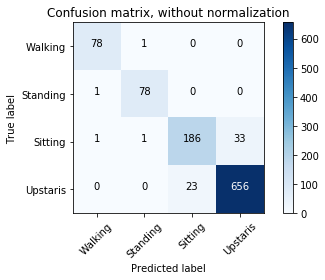

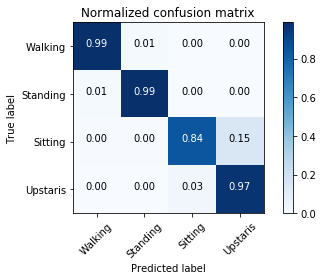

In [88]:
show_conf_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), label)

In [89]:
show_clf_report(y_test, y_pred, label)

             precision    recall  f1-score   support

    Walking       0.97      0.99      0.98        79
   Standing       0.97      0.99      0.98        79
    Sitting       0.89      0.84      0.87       221
   Upstaris       0.95      0.97      0.96       679

avg / total       0.94      0.94      0.94      1058



## Save Model and Weight

In [90]:
m.save_weights("./model/model_2.1.h5")
m.save("./model/Arc_model_2.1.h5")

## Other Dataset

In [91]:
%run load_dataset.ipynb

Loading 1001's data
Loading 1002's data
Loading 1003's data
Loading 1004's data
Loading 1005's data
Loading 1006's data
Loading 1007's data
Loading 1008's data
Loading 1009's data
Loading 1010's data
Loading 1011's data
Loading 1012's data
Loading 2001's data
Loading 2002's data
Finished loading


## Data preprocessing

In [92]:
%run preprocess_for_SVM.ipynb

In [93]:
subj_train = ['1001','1002','1003','1004','2001']
subj_val = ['1005','1006','2002']
subj_test = ['1007','1008','1009']

In [94]:
def get_X_y(subj_ids, X, y, s):
    X_get = []
    y_get = []
    s_get = []
    for i in range(len(s)):
        for j in range(len(subj_ids)):
            if(s[i]==subj_ids[j]):
                X_get.append(X[i])
                y_get.append(y[i])
                s_get.append(s[i])
                
    return np.array(X_get), np.array(y_get), np.array(s_get)

In [95]:
X_train2, y_train2, s_train = get_X_y(subj_train, X_all, y_all, subj_all)
X_val, y_val, s_val = get_X_y(subj_val, X_all, y_all, subj_all)
X_test2, y_test2, s_test = get_X_y(subj_test, X_all, y_all, subj_all)

In [96]:
def prepare_pure(X, y, subj_all, new_label_list):
    X_label, y_label = label_grouping(X, y, subj_all, new_label_list)
    
    X_concat = []
    y_concat = []
    for i in range(len(X_label)):
        for j in range(len(X_label[i])):
            X_ol, y_ol = make_overlapping(np.array(X_label[i][j]), y_label[i][j])
#             print(i, j, X_ol.shape)
            
            if(len(X_concat)==0):
                X_concat = X_ol
            else:
                X_concat = np.vstack((X_concat, X_ol))

            if(len(y_concat)==0):
                y_concat = y_ol
            else:
                y_concat = np.hstack((y_concat, y_ol))
                
#     X_concat_xyz = concat_xyz(X_concat)
    
    return X_concat, y_concat    

In [97]:
X_label, y_label = label_grouping(X_train2, y_train2, s_train, label_list)

In [98]:
print(X_train2.shape,y_train2.shape,s_train.shape)

(10042, 3) (10042,) (10042,)


In [99]:
label_list = [0,1,2,3]
label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

all_subjects = subj_train
X_train_pure, y_train_pure = prepare_pure(X_train2, y_train2, s_train, label_list)

all_subjects = subj_val
X_val_pure, y_val_pure = prepare_pure(X_val, y_val, s_val, label_list)


all_subjects = subj_test
X_test_pure, y_test_pure = prepare_pure(X_test2, y_test2, s_test, label_list)

In [100]:
VAL_LEN = X_val_pure.shape[0]
X_train_pure = X_train_pure[:VAL_LEN]
y_train_pure = y_train_pure[:VAL_LEN]

print(VAL_LEN)
print(y_train_pure.shape[0])

5275
5275


In [101]:
LABEL_COUNT = 4

In [102]:
def reshape_y(y):
    
    y_rs_ = label_binarize(y, classes=[0,1,2,3])
    
    y_rs = []
    #for i in range(len(y_rs_)):
     #   y_temp = []
      #  for j in range(window_length):
       #     y_temp.append(y_rs_[i])
            
       # y_rs.append(np.array(y_temp))
        
    y_rs = np.array(y_rs_)
    y_rs = y_rs.reshape((y_rs.shape[0],LABEL_COUNT))
        
    return np.array(y_rs)

In [103]:
def reshape_X(X):
    X_rs = X.reshape((X.shape[0],1,X.shape[1]))
    return X_rs

In [104]:
y_train_rs = reshape_y(y_train_pure)
y_val_rs = reshape_y(y_val_pure)
y_test_rs = reshape_y(y_test_pure)

In [105]:
print(X_train_pure.shape)
print(X_train_pure.shape[1])
print(X_train_pure.shape[2])
print(y_train_rs.shape)
print(y_train_pure.shape)

(5275, 60, 3)
60
3
(5275, 4)
(5275,)


## Load model

In [106]:
model = load_model("./model/Arc_model_2.1.h5")

In [107]:
adam = optimizers.Adam(lr = 0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [108]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 3)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 32)            1088      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 15, 32)            11296     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
__________

In [109]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=10,
                                verbose=1, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=20, verbose=0, mode='max')

model_1_path = "./model/model_1/{}.h5".format("model_1")
checkpoint = ModelCheckpoint(model_1_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

history1 = model.fit(X_train_pure, y_train_rs, epochs = 100,  callbacks=callbacks_list, verbose =1 , validation_data=(X_val_pure, y_val_rs))

Train on 5275 samples, validate on 5275 samples
Epoch 1/100
5216/5275 [============================>.] - ETA: 0s - loss: 0.2888 - acc: 0.8995
Epoch 00001: val_acc improved from -inf to 0.60417, saving model to ./model/model_1/model_1.h5
5275/5275 [==============================] - 5s 959us/step - loss: 0.2856 - acc: 0.9007 - val_loss: 4.8403 - val_acc: 0.6042
Epoch 2/100
5216/5275 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9887
Epoch 00002: val_acc did not improve
5275/5275 [==============================] - 3s 648us/step - loss: 0.0383 - acc: 0.9888 - val_loss: 4.9148 - val_acc: 0.5581
Epoch 3/100
5184/5275 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9963
Epoch 00003: val_acc did not improve
5275/5275 [==============================] - 4s 688us/step - loss: 0.0116 - acc: 0.9964 - val_loss: 5.4224 - val_acc: 0.5831
Epoch 4/100
5216/5275 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9919
Epoch 00004: val_acc did not imp

## Plot acc and loss

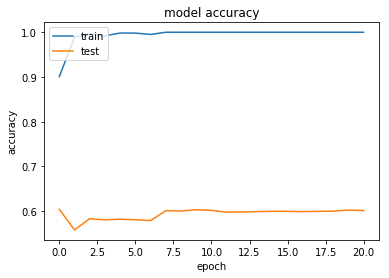

In [110]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

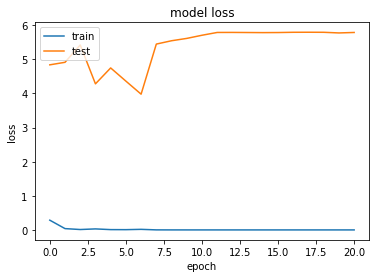

In [111]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict

In [112]:
num_classes = 4

In [113]:
y_pred2 = model.predict(X_test_pure)
print(y_pred2.shape)
print(y_test_rs.shape)

(5274, 4)
(5274, 4)


In [114]:
y_pred2 = np.argmax(y_pred2, axis=1)

In [115]:
print(y_pred2.shape)
print(y_test_rs.shape)

(5274,)
(5274, 4)


In [116]:
y_pred2 = np_utils.to_categorical(y_pred2, num_classes)

In [117]:
print(y_pred2.shape)
print(y_test_rs.shape)

(5274, 4)
(5274, 4)


In [118]:
y_pred2 = np.array(y_pred2)
y_test_rs = np.array(y_test_rs)

In [119]:
print(y_pred2)
print(y_test_rs)

[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 ..., 
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ..., 
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [120]:
LABELS = list(label_dict.values())

## Visualization

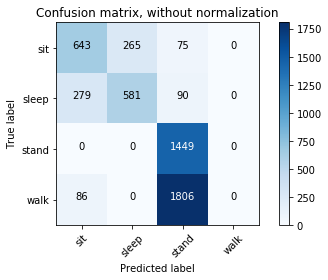

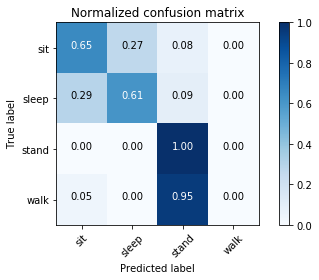

In [121]:
show_conf_matrix(y_test_rs.argmax(axis=1), y_pred2.argmax(axis=1), LABELS)

In [122]:
show_clf_report(y_test_rs, y_pred2, LABELS)

             precision    recall  f1-score   support

        sit       0.64      0.65      0.65       983
      sleep       0.69      0.61      0.65       950
      stand       0.42      1.00      0.60      1449
       walk       0.00      0.00      0.00      1892

avg / total       0.36      0.51      0.40      5274



C:\Users\fifamd\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
